Using device: cpu
원본 데이터 shape: (7043, 21)
Base LTV train 예시: [0.9 1.2 1.2 0.9 2.4]
X_train: (5634, 30) X_test: (1409, 30)

=== Run: Double DQN, config=base, seed=0 ===


/tmp/ipython-input-398187431.py:328: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states_t = torch.tensor(states, dtype=torch.float32, device=self.device)



=== Run: Double DQN, config=base, seed=1 ===

=== Run: Double DQN, config=base, seed=21 ===

=== Run: Double DQN, config=base, seed=42 ===

=== Run: Double DQN, config=base, seed=123 ===

=== Run: Double DQN, config=slow_decay, seed=0 ===

=== Run: Double DQN, config=slow_decay, seed=1 ===

=== Run: Double DQN, config=slow_decay, seed=21 ===

=== Run: Double DQN, config=slow_decay, seed=42 ===

=== Run: Double DQN, config=slow_decay, seed=123 ===

=== Run: Double DQN, config=high_lr, seed=0 ===

=== Run: Double DQN, config=high_lr, seed=1 ===

=== Run: Double DQN, config=high_lr, seed=21 ===

=== Run: Double DQN, config=high_lr, seed=42 ===

=== Run: Double DQN, config=high_lr, seed=123 ===

총 실험 수: 15

===== Summary (config별 LTV 및 개선률, 95% CI) =====
  config_name  n  baseline_no_action  baseline_random  baseline_greedy  \
0        base  5            0.795245         0.812948         1.072337   
1     high_lr  5            0.795245         0.812948         1.072337   
2  slow_decay  5

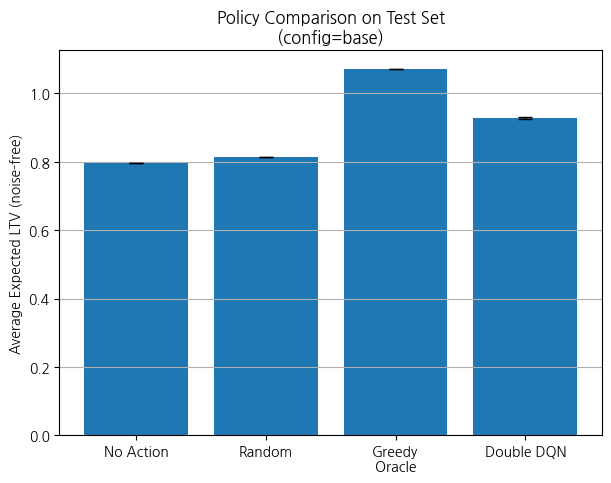


[Config: high_lr]


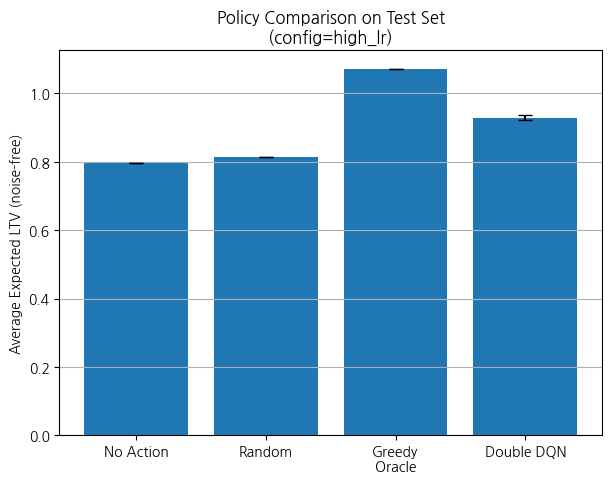


[Config: slow_decay]


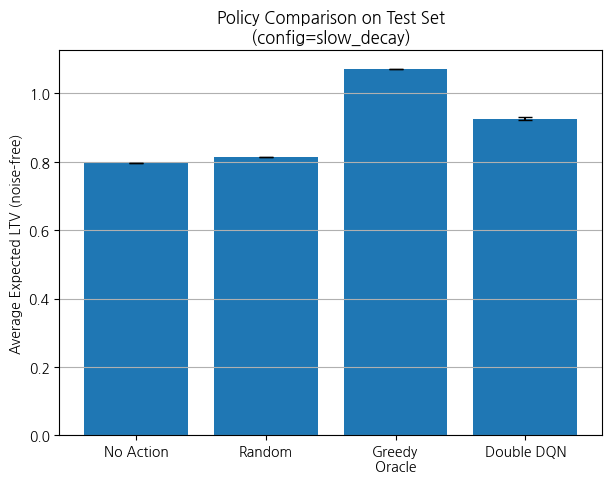

In [1]:
!git clone https://github.com/jou1207-source/a71033_jaegonsong.git
%cd a71033_jaegonsong
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

# ============================================
# 0. 기본 설정 & 라이브러리 임포트
# ============================================
import numpy as np
import pandas as pd
import random
from collections import deque, defaultdict
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_name = fm.FontProperties(fname = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf', size = 10).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 장비 & 시드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_global_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# ============================================
# 1. 데이터 로드 & 전처리
# ============================================
file_path = "./data/Telco_Customer_Churn_Data.csv"
df = pd.read_csv(file_path)

print("원본 데이터 shape:", df.shape)

# 숫자형 변환: TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# 타깃 y 분리 (Churn: Yes=1, No=0)
y = df["Churn"].map({"Yes": 1, "No": 0}).values

# 특징 X에서 ID와 타깃 제거
X_raw = df.drop(["customerID", "Churn"], axis=1)

# --------------------------------------------
# 1-1. Train / Test split
# --------------------------------------------
seed_data_split = 42
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw,
    y,
    test_size=0.2,
    random_state=seed_data_split,
    stratify=y,
)

# --------------------------------------------
# 1-2. Base LTV 계산 (tenure 기반)
# --------------------------------------------
def expected_remaining_months(tenure):
    """
    간단한 잔여기간 가정:
    - tenure < 6  : 24개월
    - 6~12        : 18개월
    - 12~24       : 12개월
    - 24~48       : 9개월
    - 48 이상     : 6개월
    """
    if tenure < 6:
        return 24
    elif tenure < 12:
        return 18
    elif tenure < 24:
        return 12
    elif tenure < 48:
        return 9
    else:
        return 6

monthly_margin = 0.1  # 월 마진 (임의 스케일)

tenure_train = X_train_raw["tenure"].values
tenure_test  = X_test_raw["tenure"].values

base_ltv_train = np.array(
    [expected_remaining_months(t) * monthly_margin for t in tenure_train],
    dtype=np.float32,
)
base_ltv_test = np.array(
    [expected_remaining_months(t) * monthly_margin for t in tenure_test],
    dtype=np.float32,
)

print("Base LTV train 예시:", base_ltv_train[:5])

# --------------------------------------------
# 1-3. 범주형 변수 원-핫 인코딩 + 스케일링
# --------------------------------------------
train_size = len(X_train_raw)
full = pd.concat([X_train_raw, X_test_raw], axis=0)
full_encoded = pd.get_dummies(full, drop_first=True)

X_train_df = full_encoded.iloc[:train_size, :]
X_test_df  = full_encoded.iloc[train_size:, :]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df).astype(np.float32)
X_test  = scaler.transform(X_test_df).astype(np.float32)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


# ============================================
# 2. LTV 기반 강화학습 환경 (Reward 2.1)
# ============================================
class LTVChurnEnv:
    """
    - 상태: feature vector (X 한 줄)
    - base_ltv: tenure 기반 LTV
    - y: churn(1)/non-churn(0)

    액션(action): 0~3
        0: no_action
        1: discount
        2: reminder
        3: extension

    보상: 선택한 액션의 기대 LTV (noise 포함)
    """

    def __init__(self, X, y, base_ltv, seed=42):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.base_ltv = base_ltv.astype(np.float32)

        assert len(self.X) == len(self.y) == len(self.base_ltv)

        self.n_samples = self.X.shape[0]
        self.n_features = self.X.shape[1]

        self.actions = ["no_action", "discount", "reminder", "extension"]
        self.n_actions = len(self.actions)

        self.rng = np.random.default_rng(seed)
        self.current_idx = None

    def reset(self):
        self.current_idx = self.rng.integers(0, self.n_samples)
        return self.X[self.current_idx]

    def _expected_ltv_after_action(self, base_churn, base_ltv, action):
        # 유지 고객(non-churn): 개입 패널티
        if not base_churn:
            if action == 0:      # no_action
                return 1.00 * base_ltv
            elif action == 1:    # discount
                return 0.60 * base_ltv
            elif action == 2:    # reminder
                return 0.90 * base_ltv
            elif action == 3:    # extension
                return 0.85 * base_ltv
            else:
                raise ValueError("잘못된 action index")

        # 이탈 예정 고객(churn): LTV 세그먼트
        if base_ltv < 1.0:
            segment = "low"
        elif base_ltv < 1.8:
            segment = "mid"
        else:
            segment = "high"

        if segment == "low":
            if action == 0:
                return 0.0
            elif action == 1:
                return 0.25 * base_ltv
            elif action == 2:    # best
                return 0.50 * base_ltv
            elif action == 3:
                return 0.35 * base_ltv

        elif segment == "mid":
            if action == 0:
                return 0.0
            elif action == 1:
                return 0.45 * base_ltv
            elif action == 2:
                return 0.35 * base_ltv
            elif action == 3:    # best
                return 0.55 * base_ltv

        else:  # high
            if action == 0:
                return 0.0
            elif action == 1:    # best
                return 0.65 * base_ltv
            elif action == 2:
                return 0.30 * base_ltv
            elif action == 3:
                return 0.50 * base_ltv

        raise ValueError("잘못된 action index")

    def step(self, action: int):
        y_true = self.y[self.current_idx]
        base_churn = (y_true == 1)
        base_ltv = self.base_ltv[self.current_idx]

        expected_ltv = self._expected_ltv_after_action(base_churn, base_ltv, action)
        noise = self.rng.normal(loc=0.0, scale=0.01)
        reward = float(expected_ltv + noise)

        info = {
            "churn_label": int(base_churn),
            "base_ltv": float(base_ltv),
            "expected_ltv": float(expected_ltv),
        }

        next_state = self.reset()
        done = True
        return next_state, reward, done, info


def make_envs(env_seed: int):
    train_env = LTVChurnEnv(X_train, y_train, base_ltv_train, seed=env_seed)
    test_env  = LTVChurnEnv(X_test,  y_test,  base_ltv_test,  seed=env_seed + 1000)
    return train_env, test_env


# ============================================
# 3. Q-network & Double DQN 에이전트
# ============================================
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class DoubleDQNAgent:
    def __init__(
        self,
        state_size,
        action_size,
        lr=5e-4,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.02,
        epsilon_decay=0.997,
        batch_size=64,
        memory_size=50_000,
        device=None,
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = QNetwork(state_size, action_size).to(self.device)
        self.target_net = QNetwork(state_size, action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = deque(maxlen=memory_size)
        self.steps_done = 0

    def select_action(self, state):
        self.steps_done += 1
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)

        with torch.no_grad():
            s = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            q = self.policy_net(s)
            return int(q.argmax(dim=1).item())

    def select_action_greedy(self, state):
        with torch.no_grad():
            s = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            q = self.policy_net(s)
            return int(q.argmax(dim=1).item())

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append(
            (
                state.astype(np.float32),
                int(action),
                float(reward),
                next_state.astype(np.float32),
                bool(done),
            )
        )

    def update(self):
        if len(self.memory) < self.batch_size:
            return None

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states_t = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions_t = torch.tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards_t = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states_t = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones_t = torch.tensor(dones, dtype=torch.float32, device=self.device).unsqueeze(1)

        q_values = self.policy_net(states_t).gather(1, actions_t)

        with torch.no_grad():
            next_q_policy = self.policy_net(next_states_t)
            next_actions = next_q_policy.argmax(1, keepdim=True)
            next_q_target = self.target_net(next_states_t).gather(1, next_actions)
            target_q = rewards_t + self.gamma * next_q_target * (1 - dones_t)

        loss = nn.MSELoss()(q_values, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay

        return float(loss.item())

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


# ============================================
# 4. 학습 & 정책 평가 함수
# ============================================
def train_ddqn(
    env,
    agent,
    num_episodes=400,
    steps_per_episode=250,
    target_update=10,
    verbose=False,
):
    rewards, losses, epsilons = [], [], []

    for ep in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0.0
        ep_losses = []

        for _ in range(steps_per_episode):
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)
            loss = agent.update()
            if loss is not None:
                ep_losses.append(loss)

            total_reward += reward
            state = next_state

        rewards.append(total_reward)
        losses.append(np.mean(ep_losses) if ep_losses else None)
        epsilons.append(agent.epsilon)

        if ep % target_update == 0:
            agent.update_target_network()

        if verbose and (ep == 1 or ep % 50 == 0 or ep == num_episodes):
            print(
                f"  Episode {ep}/{num_episodes} | "
                f"Reward: {total_reward:.3f} | "
                f"Mean loss: {None if losses[-1] is None else round(losses[-1],4)} | "
                f"Epsilon: {agent.epsilon:.4f}"
            )

    return rewards, losses, epsilons


def compute_ltv_policy(env, agent=None, policy_type="no_action"):
    """
    policy_type:
        - "no_action": 항상 no_action(0)
        - "random": 4개 액션 균등 랜덤
        - "greedy": 환경의 true reward를 알고 있다고 가정하고,
                    각 (churn, base_ltv)에 대해 즉시 LTV를 최대화하는 액션 선택
        - "rl": 학습된 Double DQN 정책 (greedy)
    """
    rng = np.random.default_rng(12345)
    total_ltv = 0.0
    n = env.n_samples
    action_counts = np.zeros(env.n_actions, dtype=int)

    for i in range(n):
        state = env.X[i]
        base_ltv = env.base_ltv[i]
        base_churn = (env.y[i] == 1)

        if policy_type == "no_action":
            action = 0

        elif policy_type == "random":
            action = rng.integers(0, env.n_actions)

        elif policy_type == "greedy":
            best_a = None
            best_val = -1e9
            for a in range(env.n_actions):
                val = env._expected_ltv_after_action(base_churn, base_ltv, a)
                if val > best_val:
                    best_val = val
                    best_a = a
            action = best_a

        elif policy_type == "rl":
            assert agent is not None
            action = agent.select_action_greedy(state)

        else:
            raise ValueError("policy_type은 'no_action'|'random'|'greedy'|'rl' 중 하나")

        exp_ltv = env._expected_ltv_after_action(base_churn, base_ltv, action)
        total_ltv += exp_ltv
        action_counts[action] += 1

    avg_ltv = total_ltv / n
    action_probs = action_counts / action_counts.sum()
    return avg_ltv, action_counts, action_probs


# ============================================
# 5. 실험 세팅 (Double DQN + 여러 config + 여러 seed)
# ============================================
SEEDS = [0, 1, 21, 42, 123]

BASE_TRAIN_PARAMS = {
    "gamma": 0.99,
    "batch_size": 64,
    "memory_size": 50_000,
    "num_episodes": 400,
    "steps_per_episode": 250,
    "target_update": 10,
}

CONFIGS = [
    {
        "name": "base",
        "lr": 5e-4,
        "epsilon_end": 0.02,
        "epsilon_decay": 0.997,
        **BASE_TRAIN_PARAMS,
    },
    {
        "name": "slow_decay",
        "lr": 5e-4,
        "epsilon_end": 0.02,
        "epsilon_decay": 0.999,
        **BASE_TRAIN_PARAMS,
    },
    {
        "name": "high_lr",
        "lr": 1e-3,
        "epsilon_end": 0.02,
        "epsilon_decay": 0.997,
        **BASE_TRAIN_PARAMS,
    },
]

all_results = []

for cfg in CONFIGS:
    for s in SEEDS:
        print(f"\n=== Run: Double DQN, config={cfg['name']}, seed={s} ===")
        set_global_seed(s)
        train_env, test_env = make_envs(s)

        agent = DoubleDQNAgent(
            state_size=train_env.n_features,
            action_size=train_env.n_actions,
            lr=cfg["lr"],
            gamma=cfg["gamma"],
            epsilon_start=1.0,
            epsilon_end=cfg["epsilon_end"],
            epsilon_decay=cfg["epsilon_decay"],
            batch_size=cfg["batch_size"],
            memory_size=cfg["memory_size"],
            device=device,
        )

        rewards, losses, eps = train_ddqn(
            train_env,
            agent,
            num_episodes=cfg["num_episodes"],
            steps_per_episode=cfg["steps_per_episode"],
            target_update=cfg["target_update"],
            verbose=False,
        )

        # 네 가지 정책의 expected LTV 측정 (noise-free)
        noact_avg, _, _ = compute_ltv_policy(test_env, policy_type="no_action")
        rand_avg, _, _   = compute_ltv_policy(test_env, policy_type="random")
        greedy_avg, _, _ = compute_ltv_policy(test_env, policy_type="greedy")
        rl_avg, _, _     = compute_ltv_policy(test_env, agent=agent, policy_type="rl")

        all_results.append(
            {
                "config_name": cfg["name"],
                "seed": s,
                "train_rewards": rewards,
                "baseline_no_action": noact_avg,
                "baseline_random": rand_avg,
                "baseline_greedy": greedy_avg,
                "rl_avg_ltv": rl_avg,
                "improvement_over_no_action": rl_avg / noact_avg - 1.0,
                "improvement_over_random": rl_avg / rand_avg - 1.0,
                "gap_to_greedy": greedy_avg - rl_avg,
            }
        )

print("\n총 실험 수:", len(all_results))


# ============================================
# 6. 요약 통계 (평균, 표준편차, 95% CI)
# ============================================
results_df = pd.DataFrame(all_results)

summary_rows = []
for cfg_name, group in results_df.groupby("config_name"):
    n = len(group)

    # baseline 값은 seed마다 동일하지만, random는 seed에 따라 조금씩 달 수 있음
    mean_noact = group["baseline_no_action"].mean()
    mean_rand  = group["baseline_random"].mean()
    mean_greedy = group["baseline_greedy"].mean()

    mean_rl = group["rl_avg_ltv"].mean()
    std_rl  = group["rl_avg_ltv"].std(ddof=1)
    se_rl   = std_rl / math.sqrt(n)
    ci_rl   = 1.96 * se_rl

    mean_imp_noact = group["improvement_over_no_action"].mean()
    std_imp_noact  = group["improvement_over_no_action"].std(ddof=1)
    se_imp_noact   = std_imp_noact / math.sqrt(n)
    ci_imp_noact   = 1.96 * se_imp_noact

    mean_imp_rand = group["improvement_over_random"].mean()
    std_imp_rand  = group["improvement_over_random"].std(ddof=1)
    se_imp_rand   = std_imp_rand / math.sqrt(n)
    ci_imp_rand   = 1.96 * se_imp_rand

    mean_gap_greedy = group["gap_to_greedy"].mean()
    std_gap_greedy  = group["gap_to_greedy"].std(ddof=1)
    se_gap_greedy   = std_gap_greedy / math.sqrt(n)
    ci_gap_greedy   = 1.96 * se_gap_greedy

    summary_rows.append(
        {
            "config_name": cfg_name,
            "n": n,
            "baseline_no_action": mean_noact,
            "baseline_random": mean_rand,
            "baseline_greedy": mean_greedy,
            "mean_rl_avg_ltv": mean_rl,
            "std_rl_avg_ltv": std_rl,
            "ci95_rl_avg_ltv": ci_rl,
            "mean_imp_over_no_action": mean_imp_noact,
            "ci95_imp_over_no_action": ci_imp_noact,
            "mean_imp_over_random": mean_imp_rand,
            "ci95_imp_over_random": ci_imp_rand,
            "mean_gap_to_greedy": mean_gap_greedy,
            "ci95_gap_to_greedy": ci_gap_greedy,
        }
    )

summary_df = pd.DataFrame(summary_rows)
print("\n===== Summary (config별 LTV 및 개선률, 95% CI) =====")
print(summary_df)


# ============================================
# 7. 바 차트 시각화: 정책 4개 비교 (config별)
# ============================================
for cfg_name, group in results_df.groupby("config_name"):
    print(f"\n[Config: {cfg_name}]")

    # 평균값
    noact = group["baseline_no_action"].mean()
    rand  = group["baseline_random"].mean()
    greedy = group["baseline_greedy"].mean()
    rl_mean = group["rl_avg_ltv"].mean()
    rl_std  = group["rl_avg_ltv"].std(ddof=1)
    rl_se   = rl_std / math.sqrt(len(group))
    rl_ci   = 1.96 * rl_se

    labels = ["No Action", "Random", "Greedy\nOracle", "Double DQN"]
    means  = [noact, rand, greedy, rl_mean]
    errs   = [0.0, 0.0, 0.0, rl_ci]   # baseline들은 deterministic이라 CI=0

    x = np.arange(len(labels))

    plt.figure(figsize=(7, 5))
    plt.bar(x, means, yerr=errs, capsize=5)
    plt.xticks(x, labels)
    plt.ylabel("Average Expected LTV (noise-free)")
    plt.title(f"Policy Comparison on Test Set\n(config={cfg_name})")
    plt.grid(axis="y")
    plt.show()